## Get the data

In [0]:
!rm -rf sample_data

I am downloading the data from Kaggle directly using the Kaggle API client. This requires the use of a key provided by Kaggle in a `kaggle.json` file.

Upload the `kaggle.json` file:

In [0]:
# Upload kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [5]:
!ls

kaggle.json


Install Kaggle API client:

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

The Kaggle API client expects `kaggle.json` to be in `~/.kaggle`, so move it there, and ensure it has the correct permissions (read-write).

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Download the "Credit Card Fraud Dataset", unzip the file, and inspect:

In [8]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 86% 57.0M/66.0M [00:01<00:00, 29.4MB/s]
100% 66.0M/66.0M [00:01<00:00, 48.8MB/s]


In [9]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [10]:
!head -n 4 creditcard.csv

"Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62,"0"
0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.4639170410

## Imports

In [11]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential

Using TensorFlow backend.


## Analyze the data

In [0]:
#set up plotting params
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"] # https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list), color_codes=False)

In [13]:
df = pd.read_csv("creditcard.csv") # read in data
df.head(n=3) # check that data was imported

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [14]:
df.shape #secondary check on the size of the dataframe

(284807, 31)

The data is cleaned, and has no Null values.

In [15]:
df.isnull().values.any() #check to see if any values are null, which there are not

False

Let's see how many normal transactions vs. fraudulant transactions we have:

In [16]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

From counting the normal transactions versus the fraudulant transactions, 99.8% of the data are normal transactions. 

Visually, this looks like:

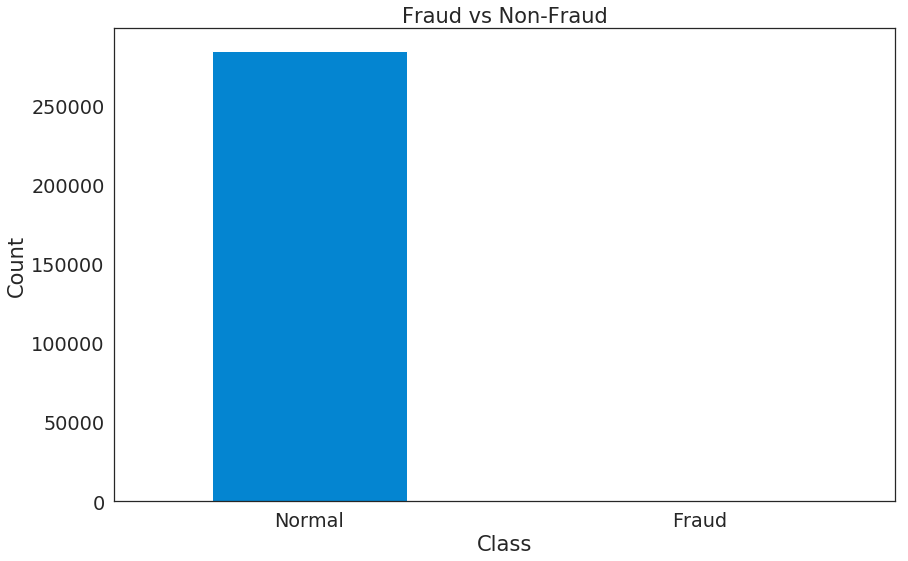

In [17]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Fraud vs Non-Fraud")
plt.xlabel("Class")
plt.ylabel("Count");

This is known as an imbalanced class problem. 99.8% is a very good accuracy for any model, so a model that returns "normal" for every transaction would be considered pretty good. Clearly, accuracy is not the metric to strive for in this case.

The metric we want is Accuracy Under the Curve (AUC). This asks, given a transaction, what is the probability that the model will accurately classify it. The score to beat is random guessing, i.e. 50%.

The data has a time column, which represents the time of the given transaction relative to the first transaction. It has a class column (0 for non-fraud, 1 for fraud). It has an amount column, which is the amount of the transaction. It then has 28 other columns, which has undergone Principal Component Analysis (PCA) for privacy concerns. Due to this there is very low correlation between columns:

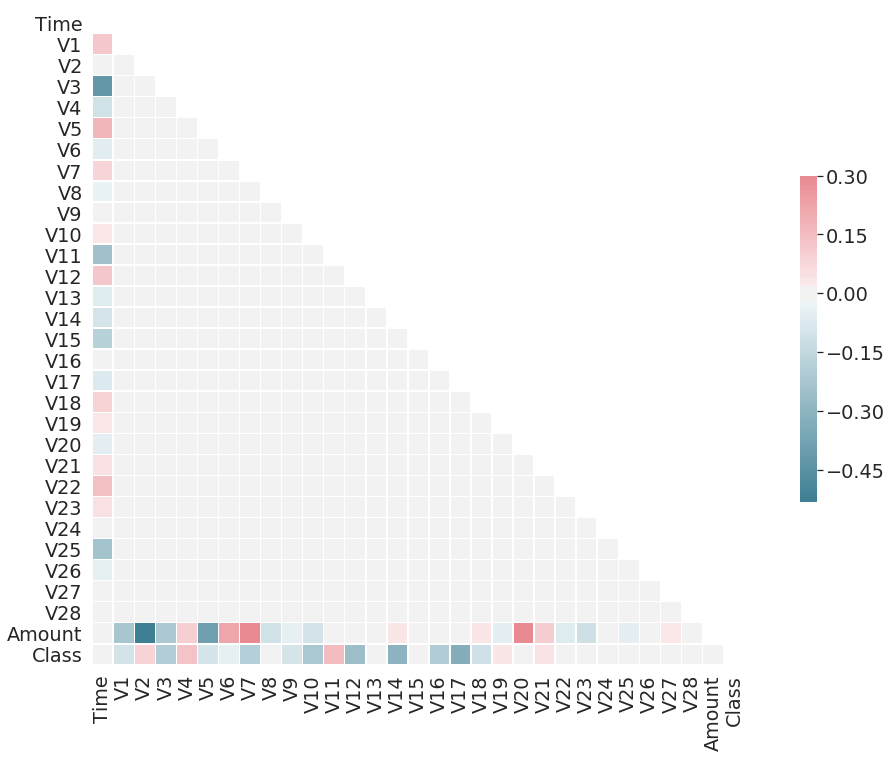

In [18]:
corr = df.corr()
 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Prepare data for training/testing

In [0]:
normal_df = df[df.Class == 0] #save normal_df observations into a separate df
fraud_df = df[df.Class == 1] #do the same for frauds

In [20]:
normal_df.shape, fraud_df.shape # as expected from counts above

((284315, 31), (492, 31))

Standardize the data to have 0 mean and a unit standard deviation:

In [0]:
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

## Lostic Regression

#### Setup and Train

The data is split into 80% training, 20% testing. The `Class` column is extracted to serve as the labels.

In [0]:
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

# split the data 80/20, training to testing
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)

train_y = train_x['Class']
train_x = train_x.drop(['Class'], axis=1)

test_y = test_x['Class']
test_x = test_x.drop(['Class'], axis=1)

# transform to ndarray
train_x = train_x.values
test_x = test_x.values

In [23]:
nb_epoch = 50
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30

model = Sequential()
model.add(Dense(120, input_shape=(input_dim,), activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(60, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
model.compile(metrics=['accuracy'],
                    loss='binary_crossentropy',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="logistic_regression_fraud.h5",
                               save_best_only=True,
                               verbose=0)

history = model.fit(train_x, train_y,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_y),
                    verbose=1,
                    callbacks=[cp]).history

Instructions for updating:
Use tf.cast instead.
Train on 227845 samples, validate on 56962 samples
Epoch 1/50
227845/227845 [==============================] - 9s 41us/step - loss: 0.0185 - acc: 0.9940 - val_loss: 0.0040 - val_acc: 0.9992
Epoch 2/50
227845/227845 [==============================] - 7s 30us/step - loss: 0.0032 - acc: 0.9993 - val_loss: 0.0040 - val_acc: 0.9992
Epoch 3/50
227845/227845 [==============================] - 7s 31us/step - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0041 - val_acc: 0.9992
Epoch 4/50
227845/227845 [==============================] - 8s 35us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.0041 - val_acc: 0.9992
Epoch 5/50
227845/227845 [==============================] - 7s 32us/step - loss: 0.0029 - acc: 0.9994 - val_loss: 0.0036 - val_acc: 0.9993
Epoch 6/50
227845/227845 [==============================] - 7s 30us/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.0038 - val_acc: 0.9992
Epoch 7/50
227845/227845 [==============================] - 7s 30us

### Binary Classification - Model Results

The model has a validation accuracy of nearly 100%, which is normally great. But, as mentioned, the data is highly unbalanced. The accuracy rate is 99.8% just by assuming all of the transactions are classified as "Normal". Instead, the goals is to predict probabilities for inputs, and define a threshold on which we assign those probabilities.

By default that threshold may be 0.5. If the probability is less than half, assign to 0 (normal), if greater, assign to 1 (fraud). But that threshold may be lowered or raised, depending on several criteria.

When making predictions for a binary, or two-class, classification problem, there are two types of errors one can make:

* **Type 1 Error**, or a false positive.
* **Type 2 Error**, or a false negative.

In this case, predicting that a given transaction is fraudulent, when in fact it is not, is a Type 1 error. Predicting a given transaction is normal, when it is really fraudulent, is a Type 2 error.

False Positives (FP) are contrasted with True Positives (TP), which would mean a fraudulent transaction was correctly predicted. False Negatives (FN) are contrasted with True Negative (TN), which means a transaction was correctly predicted as non-fraudulent, or normal.

In [0]:
model = load_model('logistic_regression_fraud.h5')

In [0]:
# preds_y = model.predict_classes(test_x).flatten()
preds_y = model.predict(test_x).flatten()

In [27]:
error_df = pd.DataFrame({'Predictions': preds_y,
                        'Actual': test_y})
error_df.describe()

,Predictions,Actual
count,56962.000000,56962.000000
mean,0.001824,0.002019
std,0.039109,0.044887
min,0.000028,0.000000
25%,0.000028,0.000000
50%,0.000029,0.000000
75%,0.000031,0.000000
max,0.999776,1.000000


#### ROC Curve

In order to see how well the model is doing with regards to Type 1 and Type 2 errors,  we how well the predictions are made against some metrics:

* The **True Positive Rate**, or *Sensitivity* is (TP)/(TP + FN).

* The **False Positive Rate** is (FP)/(FP + TN). 

  * *Specificity* is (TN)/(TN + FP) or (1 - False Positive Rate).

To graph the results of the model's prediction with respect to these metrics, the Receiver Operating Characteristic (ROC) curve is used. The ROC curve shows the trade-off between true positive vs false positive rates, for different threshold values. 

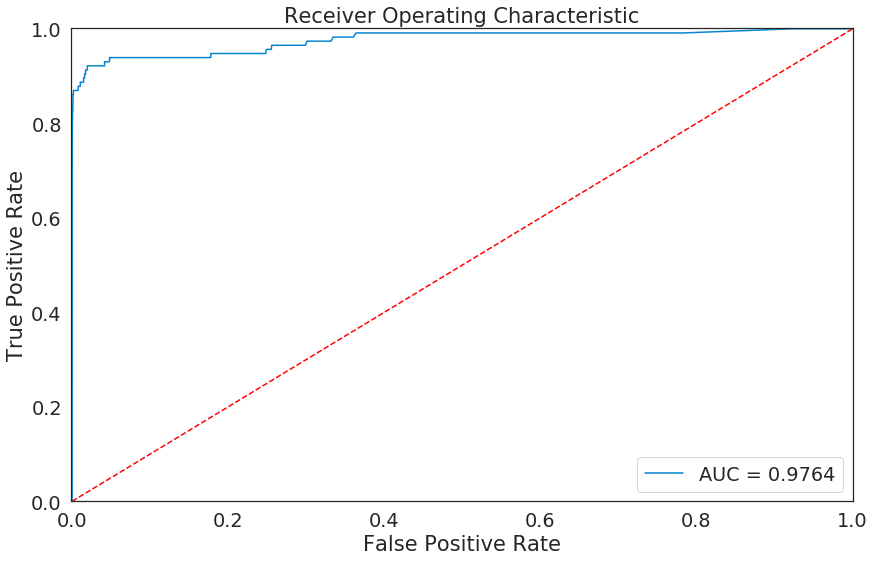

In [28]:
fpr, tpr, thresholds = roc_curve(error_df.Actual, error_df.Predictions)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The shape of this curve is unsuprising. It says that if we want a True Positive Rate to be 100%, we'll have to settle for some False Positives. AUC stands for Area Under the Curve. Skillful models will have the AUC very high, and perfect models will have it at 100%. But again, this very optimistic looking curve is a result of the large data imbalance, and doesn't help us much.

The reason for this is that the very large number of class 0 (normal) transactions means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

#### Precision-Recall Curve

While those combinations of metrics are not very useful, there are two metrics that can be used that will be informative:

* **Precision** = (TP)/(TP + FP)
* **Recall** = (TP)/(TP + FN)

Precision is also known as *Positive Predictive Power*. Recall is the same as sensitivity, i.e. the True Positive Rate.

![Precision vs Recall](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

The balance between Precision and Recall is useful for imbalanced datasets. Since neither Precision nor Recall uses True Negatives (the majority of the dataset), the combination of the two becomes very informative.

For detecting fradulent events, we want Recall to be as close to 100% as possible. However, there is always a trade off between Recall and Precision (though not necessarily 1-to-1). Higher Recall (identifying more fradulent events), means lower Precision (incorrectly flagging normal events as fradulent). The threshold mentioned above, defines where we make this trade off.

To visualize these metrics, the Precision-Recall curve is used. This curve summarizes the trade-offs between Precision and Recall, for different thresholds.

The no-skill line on a Precision-Recall curve, is the number of positive cases (fraud) divided by the number of total cases (positive and negative). For a perfectly balanced dataset (equal number of positive and negative), this is 0.5. A skillful model will have a curve that rests above this point.

In [29]:
num_fraud = error_df.Actual[error_df.Actual == 1].count()
num_normal = error_df.Actual[error_df.Actual == 0].count()
no_skill_level = num_fraud/(num_fraud + num_normal)

num_fraud, num_normal, no_skill_level

(115, 56847, 0.0020188897861732383)

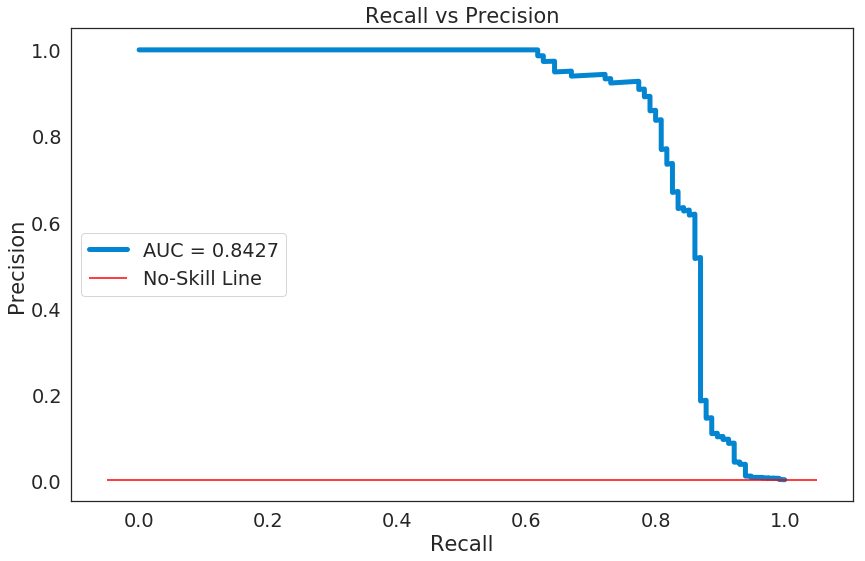

In [30]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.Actual, error_df.Predictions)
pr_auc = auc(recall_rt, precision_rt)
fig, ax = plt.subplots()
ax.plot(recall_rt, precision_rt, linewidth=5, label='AUC = %0.4f'% pr_auc)
ax.hlines(no_skill_level, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='No-Skill Line')
ax.legend(loc='center left')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

The curve its comfortably over the no-skill line for most threshold levels. Here AUC is important. The closer it is to 1 (100%), the better the model is.

Again, the goal is to have a high Recall so that as many fraudulent events are captured as possible. However the curve shows the trade off that is made: for higher values of Recall, the Precision goes down. The only way to have a near perfect Recall is to have near zero Precision, which is the same as claiming that all transactions in the dataset are fraudulent. You'll capture all the fraud events, but at the expense of inforrectly identifying all of the normal events as fradulent.

#### Defining a Threshold

In order to find good threshold values, we can plot Precision and Recall directly against different threshold values.

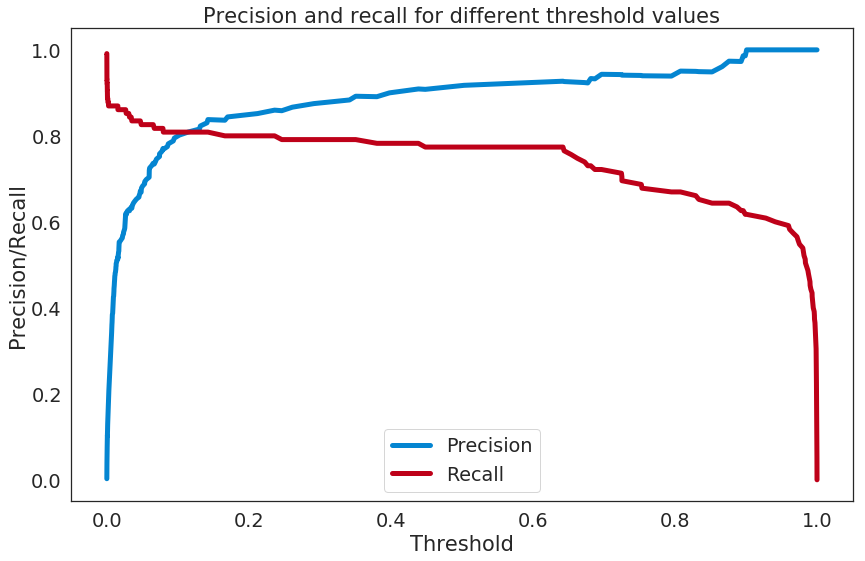

In [31]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

For both high Precision and high Recall, a low threshold is needed. 0.05 seems to be an optimal threshold. We can plot the distribution of the predictions, the probabilities the model assigned, the threshold level, and contrast actual classes (normal vs fraud).

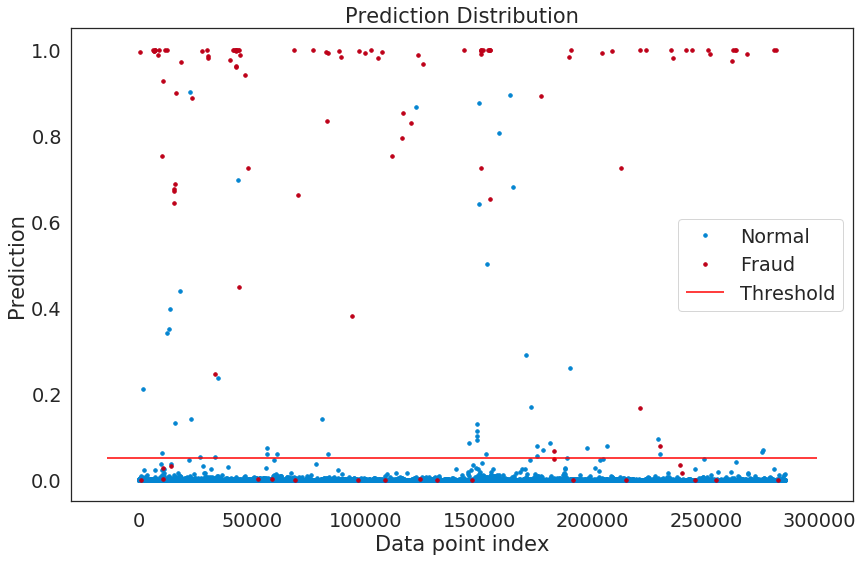

In [32]:
threshold_fixed = 0.05
groups = error_df.groupby('Actual')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Predictions, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Prediction Distribution")
plt.ylabel("Prediction")
plt.xlabel("Data point index")
plt.show();


All of the Normal points (in blue) above the threshold (red line) are false positives. All of the Fraud points (in read) above the line are true positives. We can see that if we lower the threshold much more, to capture the False Negatives, we risk far too many false positives. We can also see that raising the threshold to reduce the False Positives will dramatically reduce the number of correctly identified Fraud transactions.

#### Final Tally

In [33]:
preds_y_binary = [1 if e > threshold_fixed else 0 for e in error_df.Predictions]

print(classification_report(test_y, preds_y_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56847
           1       0.68      0.83      0.75       115

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.84      0.91      0.87     56962
weighted avg       1.00      1.00      1.00     56962



Finally we can plot a Confusion Matrix, so get exact numerical values for all combinations of True/False-Positive/Negative.

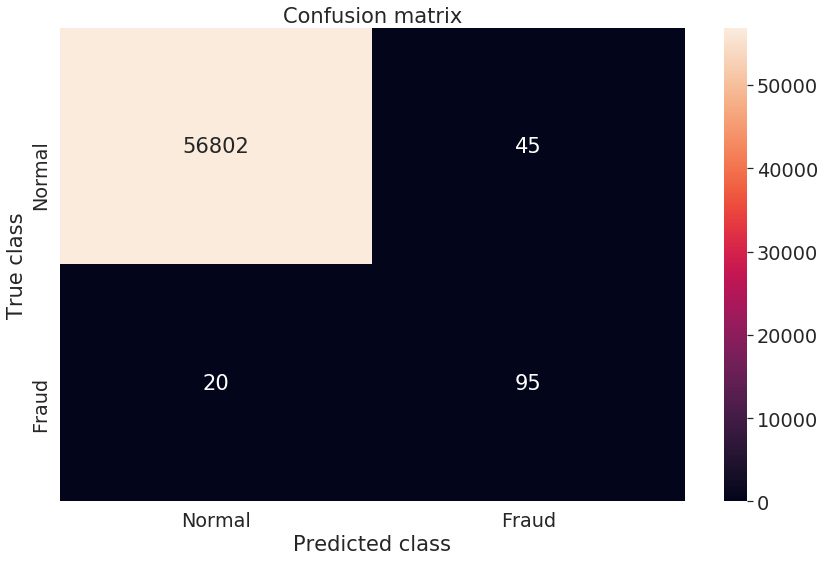

In [34]:
conf_matrix = confusion_matrix(test_y, preds_y_binary)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

95 fraud cases are correctly identified (True Positive), 20 are missed (False Negative), 45 are mis-identified as fraud (False Positive), and 56,802 are correctly categorized as normal (True Negative).

## Auto encoder Model

The point of using autoencoders is to use the input data as its own label, and come up with some useful intermediate representation (encoding). Then when running a prediction, and feeding in input data that does not fit well to the intermediate representation, then output signal that it does not fit well. This is known as **Reconstruction Error**.

For this reason we drop the fraudulant data from the training, in order to come up with an encoding for "normal" (non-fraudulant) transactions. After the model is trained, the hope is that feeding in fraudulant data will easily be flagged.

The data set has $284,807$ values, with 31 columns each. There are $284,315$ normal transactions and $492$ fraudulant ones. `df_norm` contains this data, normalized.

The data is split 80/20, training to testing.

The training data originally had $227,845$ values, but fraud data was taken out.

`train_x` is an ndarray with $227,468$ values, each with 30 columns (Class column dropped).

`test_x` is an ndarray with $56,962$ values, each with 30 columns.
$56,847$ of the values are normal transactions, $115$
are fraud.

`test_y` is a pd (pandas) data frame, which are the class values for `test_x`.

`remaining_fraud` is a pd data frame with $377$ values, each with 31 columns (Class column not dropped).

`remaining_fraud_x` is a ndarray which are the 30 non-class columns of `remaining_fraud`

`remaining_fraud_y` is a pandas Sereis, which are the class labels for `remaining_fraud_x`

`test_x_extended` is `remaining_fraud_x` + `test_x`, and has $56,962 + 377 = 57,339$ values. 

It has $377 + 115 = 492$ fraud data points.

In [0]:
# split the data 80/20, training to testing
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)

# take out the fraudulant transactions from training data
remaining_fraud = train_x[train_x.Class == 1]
# keep only normal transaction data in training set
train_x = train_x[train_x.Class == 0]
# drop the class column (labels) from training set
train_x = train_x.drop(['Class'], axis=1)

# create labels for test data
test_y = test_x['Class']
# drop the labels from test data itself
test_x = test_x.drop(['Class'], axis=1)

# transform to ndarray
train_x = train_x.values
test_x = test_x.values

In [0]:
# take out labels from remaining fraud data (taken out from training set)
remaining_fraud_y = remaining_fraud['Class']
remaining_fraud_x = remaining_fraud.drop(['Class'], axis=1).values

# extend test data and label with additional fraud data
test_x_extended = np.concatenate((remaining_fraud_x, test_x), axis=0)
test_y_extended = pd.concat([remaining_fraud_y, test_y])

### Setup and train the Autoencoder

In [0]:
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [38]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp]).history

Train on 227468 samples, validate on 56962 samples
Epoch 1/100
227468/227468 [==============================] - 6s 28us/step - loss: 0.8637 - acc: 0.4548 - val_loss: 0.8193 - val_acc: 0.5942
Epoch 2/100
227468/227468 [==============================] - 6s 27us/step - loss: 0.7666 - acc: 0.6067 - val_loss: 0.7843 - val_acc: 0.6148
Epoch 3/100
227468/227468 [==============================] - 6s 26us/step - loss: 0.7428 - acc: 0.6206 - val_loss: 0.7704 - val_acc: 0.6263
Epoch 4/100
227468/227468 [==============================] - 6s 28us/step - loss: 0.7324 - acc: 0.6287 - val_loss: 0.7626 - val_acc: 0.6363
Epoch 5/100
227468/227468 [==============================] - 7s 29us/step - loss: 0.7253 - acc: 0.6427 - val_loss: 0.7564 - val_acc: 0.6483
Epoch 6/100
227468/227468 [==============================] - 6s 27us/step - loss: 0.7188 - acc: 0.6627 - val_loss: 0.7520 - val_acc: 0.6679
Epoch 7/100
227468/227468 [==============================] - 6s 27us/step - loss: 0.7148 - acc: 0.6763 - val_

In [0]:
autoencoder = load_model('autoencoder_fraud.h5')

### Autoencoder - Model Results

We can see the accuracy of the training and testing data are very closely aligned, and flatten out near 70%. 

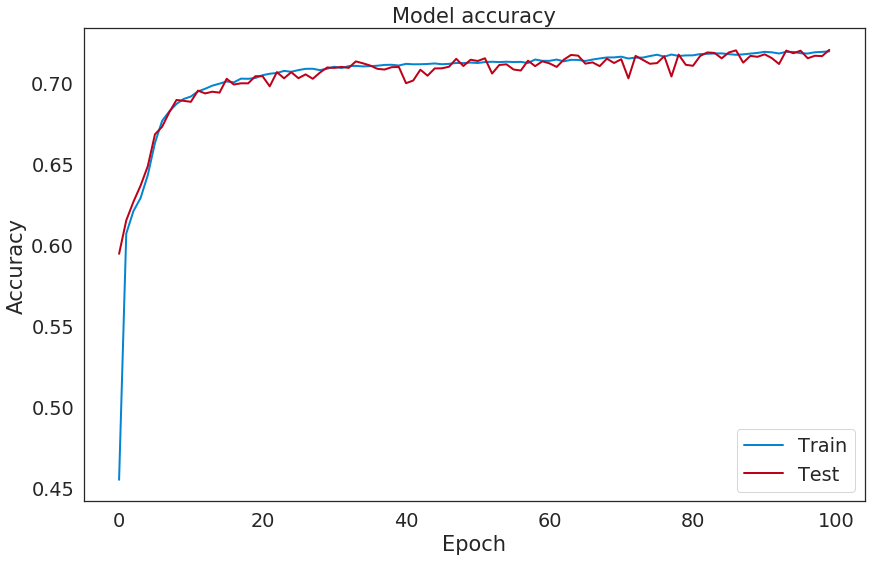

In [40]:
plt.plot(history['acc'], linewidth=2, label='Train')
plt.plot(history['val_acc'], linewidth=2, label='Test')
plt.legend(loc='lower right')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

Mean squared error near 70% for the training and 72% for the test data.

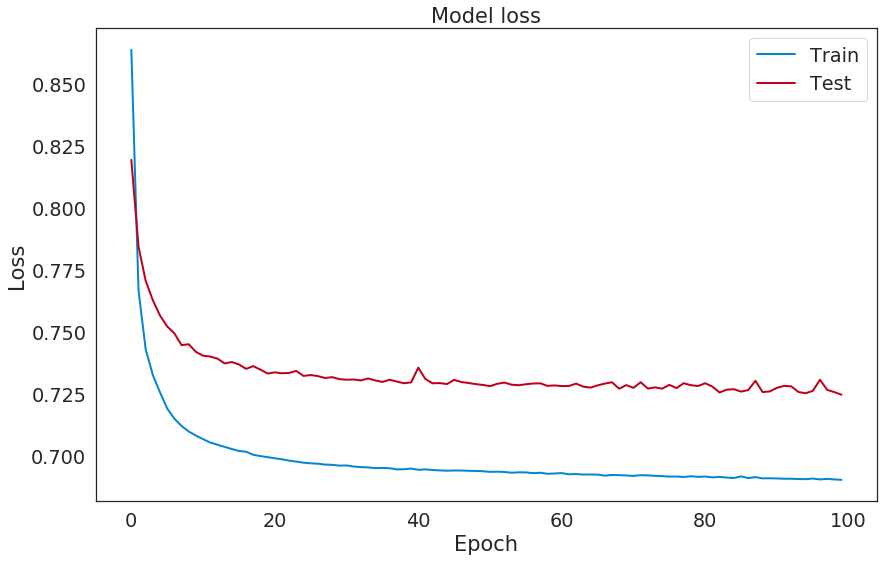

In [41]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#### Reconstruction Error

Running the predictions on the test data, we can get the reconstruction error.

In [42]:
preds = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - preds, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'Actual': test_y})
error_df.describe()

,Reconstruction_error,Actual
count,56962.000000,56962.000000
mean,0.724297,0.002019
std,3.140024,0.044887
min,0.040535,0.000000
25%,0.246993,0.000000
50%,0.386249,0.000000
75%,0.616120,0.000000
max,199.174374,1.000000


Reconstruction error of normal transactions (without fraud). We can see most of the predictions are near zero.

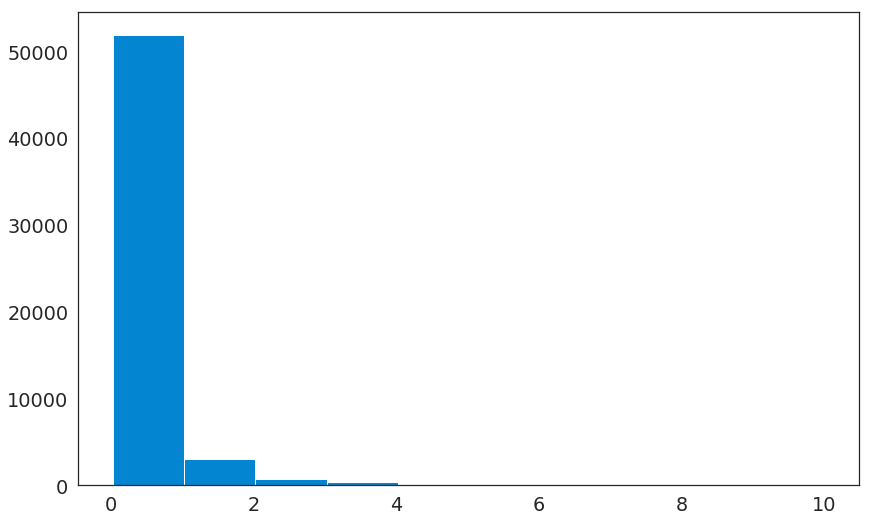

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['Actual']== 0) & (error_df['Reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.Reconstruction_error.values, bins=10)

Reconstruction error of fraud transactions. We can see the predictions are far more spread out. In simple terms, high reconstruction error values tend to mean they are fraud events.

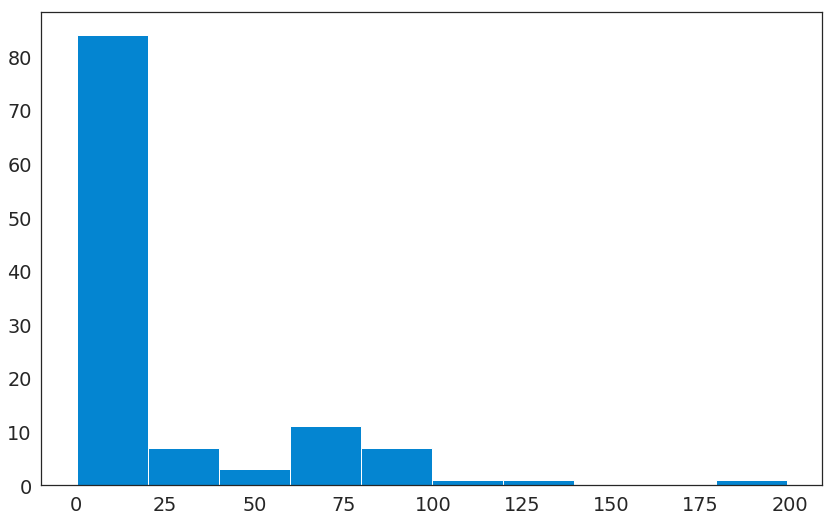

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['Actual'] == 1]
_ = ax.hist(fraud_error_df.Reconstruction_error.values, bins=10)

#### ROC Curve

Plotting the ROC curve we see again that it looks very optimisitc. But it's the same dataset as before, which is highly unbalanced, so it is not very useful.

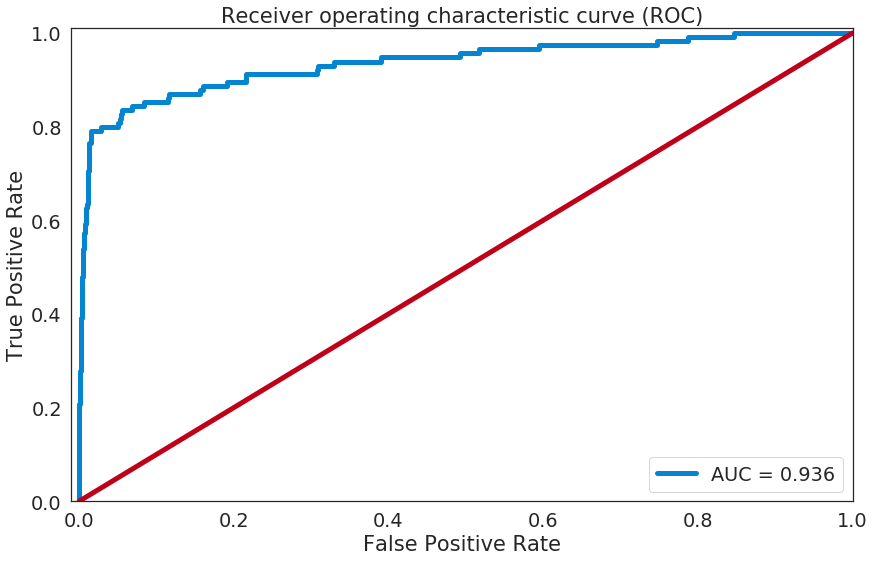

In [45]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.Actual, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Precision-Recall curve

We will again plot the Precision-Recall curve. First we define the skill level, which is the same as before.

In [46]:
num_fraud = error_df.Actual[error_df.Actual == 1].count()
num_normal = error_df.Actual[error_df.Actual == 0].count()
no_skill_level = num_fraud/(num_fraud + num_normal)

num_fraud, num_normal, no_skill_level

(115, 56847, 0.0020188897861732383)

Then calculate the precision, recall, and threshold values, as well as the AUC.

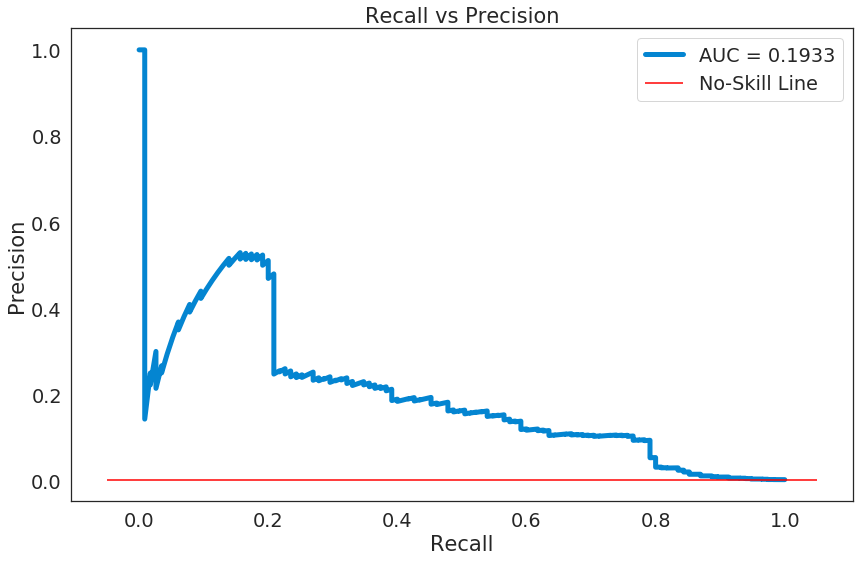

In [47]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.Actual, error_df.Reconstruction_error)
pr_auc = auc(recall_rt, precision_rt)
fig, ax = plt.subplots()
ax.plot(recall_rt, precision_rt, linewidth=5, label='AUC = %0.4f'% pr_auc)
ax.hlines(no_skill_level, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='No-Skill Line')
ax.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

While the model is skilled (above the no-skill line), the AUC is much lower than before. Previously, for the logistic regression model, the AUC was 0.8427. Now, for the Autoencoder model, it's 0.1933. We can see that Precision drops quickly, but then rises again as Recall is improved. However for Recall starting at 0.2 and above, it drops again and keeps going down.

#### Defining a Reconstruction Error Threshold

The Precision-Recall vs threshold plot looks different as well. This time we are not calculating probabilities, but reconstruction error, so the thresholds are no longer between 0 and 1, they are different values for reconstruction error.

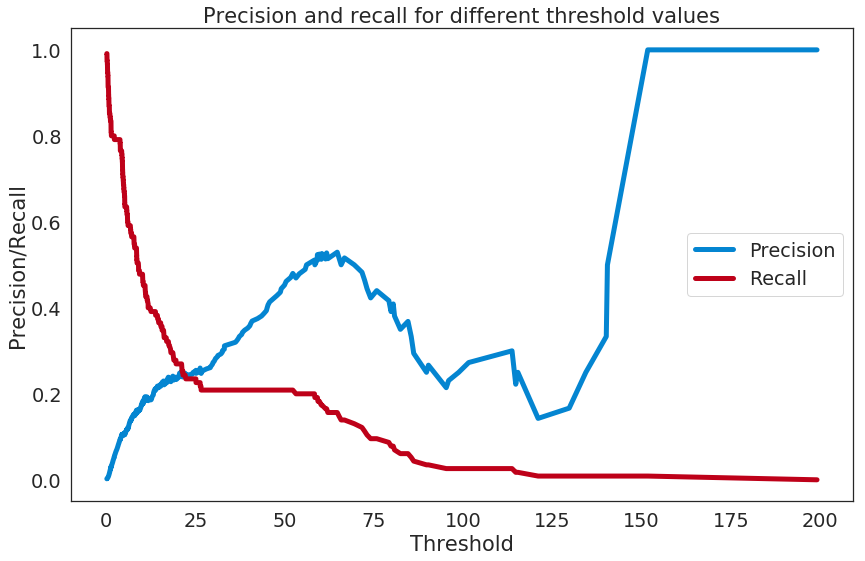

In [48]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

We can see the trade-off between Precision and Recall is more dramatic than before. We want high Recall, so will need to choose a low threshold, which means we'll have to settle for a low Precision as well.

Choosing a threshold of 10, we can plot the Reconstruction Error for different classes, against the threshold.

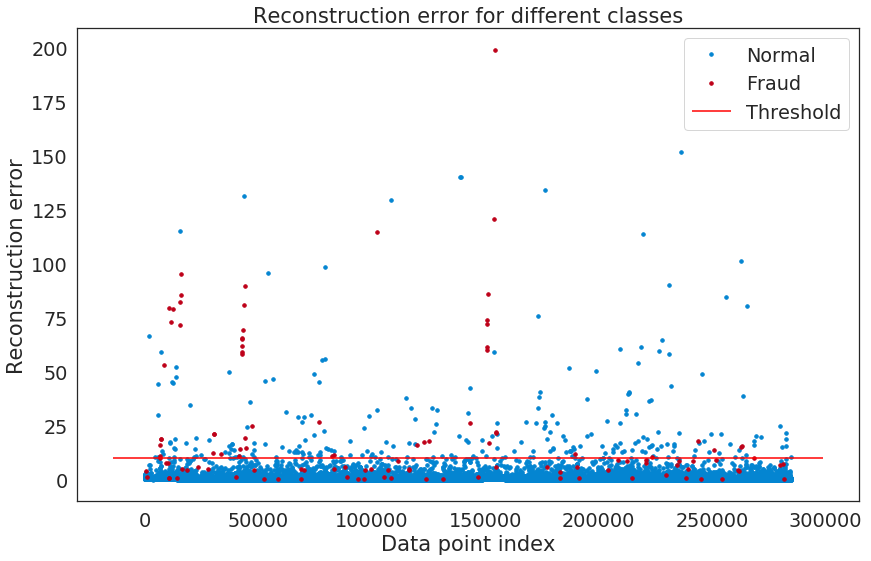

In [49]:
threshold_fixed = 10
groups = error_df.groupby('Actual')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

It's clear that while the majority of normal transactions have low reconstruction error, there are enough that have higher than average that it's very difficult to both eliminate False Positives and correctly identify True Positives.

#### Final Tally

In [50]:
preds_y_binary = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error]

print(classification_report(test_y, preds_y_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56847
           1       0.18      0.48      0.26       115

   micro avg       0.99      0.99      0.99     56962
   macro avg       0.59      0.74      0.63     56962
weighted avg       1.00      0.99      1.00     56962



Finally we plot a Confusion Matrix.

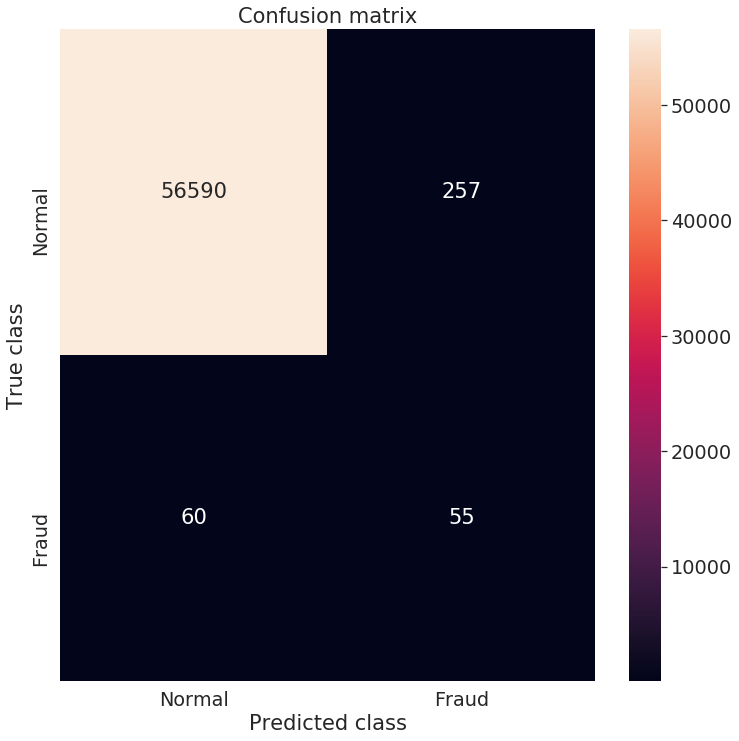

In [51]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Actual, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

We now have:

* True Positives: 55
* False Negatives: 60
* False Positives: 253
* True Positives: 56,594

Therefore:
* Precision = 55 / (55 + 253) = 0.17857 = 18%
* Recall = 55 / (55 + 50) = 0.4783 = 48%

Previously we had Recall of 83% and Precision of 68%.

So it seems the Autoencoder, while much better than an unskilled model, does not beat the more straightforward supervised learning aproach.


#### Extended Testing Data

One thing remains. When training the Autoencoder, 80% of the fraud data was put aside, since it was not needed for training. For a direct comparison against the previous model, it was important to have the test data be the same size. But now, we can reinject the fraud data that was put aside, into the test data, and redo the predictions to see how the autoencoder model does with additional fraud datapoints to identify.

In [52]:
preds = autoencoder.predict(test_x_extended)
mse = np.mean(np.power(test_x_extended - preds, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'Actual': test_y_extended})
error_df.describe()

,Reconstruction_error,Actual
count,57339.000000,57339.000000
mean,0.898199,0.008581
std,4.870698,0.092234
min,0.040535,0.000000
25%,0.247749,0.000000
50%,0.388576,0.000000
75%,0.622266,0.000000
max,276.688759,1.000000


Now we have all 492 fraud data points as part of the predictions:

In [53]:
num_fraud = error_df.Actual[error_df.Actual == 1].count()
num_normal = error_df.Actual[error_df.Actual == 0].count()
no_skill_level = num_fraud/(num_fraud + num_normal)

num_fraud, num_normal, no_skill_level

(492, 56847, 0.008580547271490609)

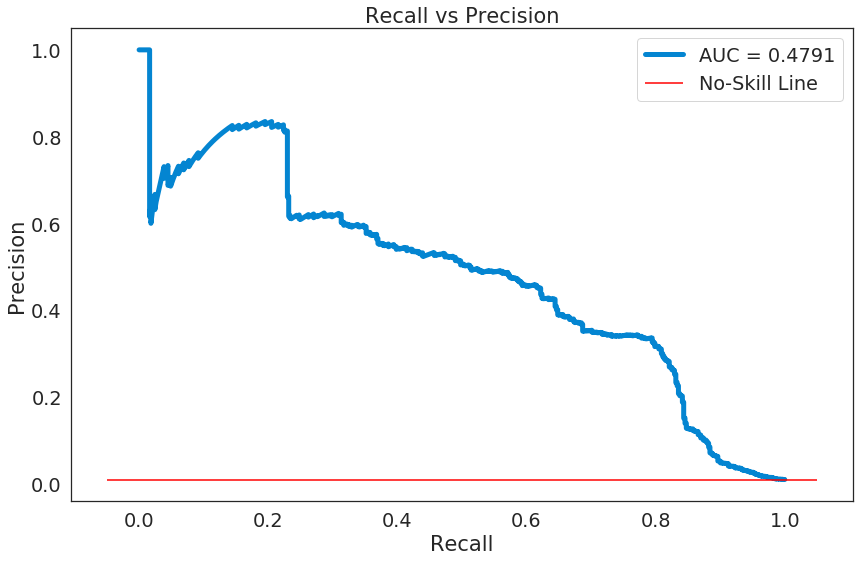

In [54]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.Actual, error_df.Reconstruction_error)
pr_auc = auc(recall_rt, precision_rt)
fig, ax = plt.subplots()
ax.plot(recall_rt, precision_rt, linewidth=5, label='AUC = %0.4f'% pr_auc)
ax.hlines(no_skill_level, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='No-Skill Line')
ax.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

The Recall-Precision curve looks the same, but AUC has doubled.

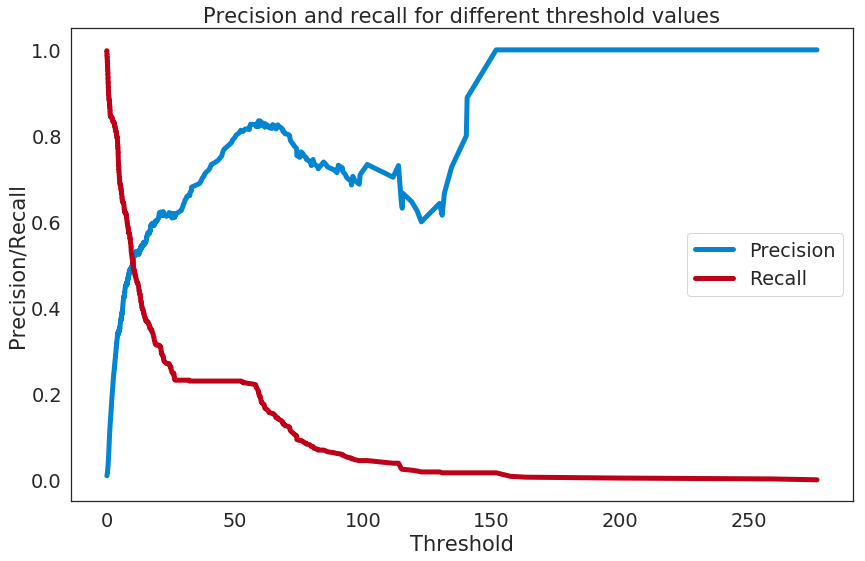

In [55]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Again, the two curves look the same as before, but now we have a bit more Precision for higher Recall values. We can't afford a higher threshold, but Recall should be slightly better.

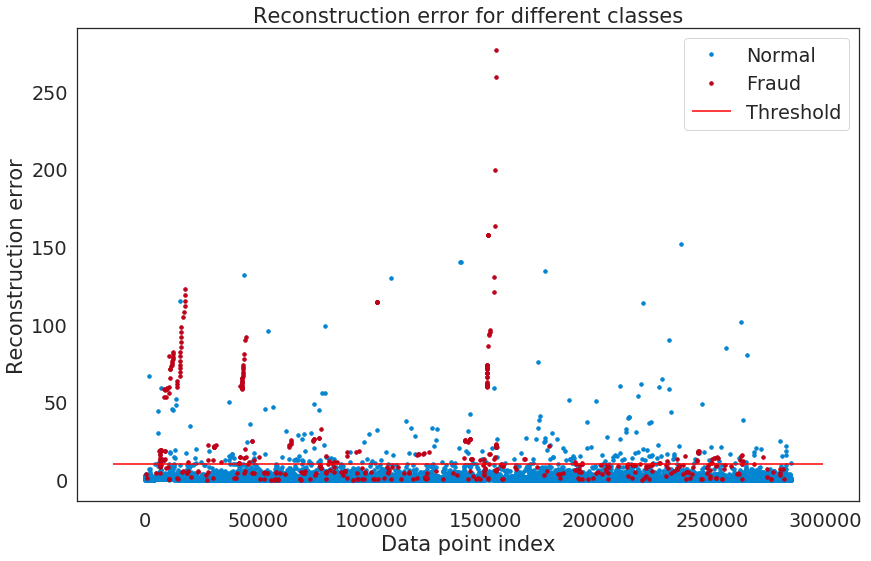

In [56]:
threshold_fixed = 10
groups = error_df.groupby('Actual')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

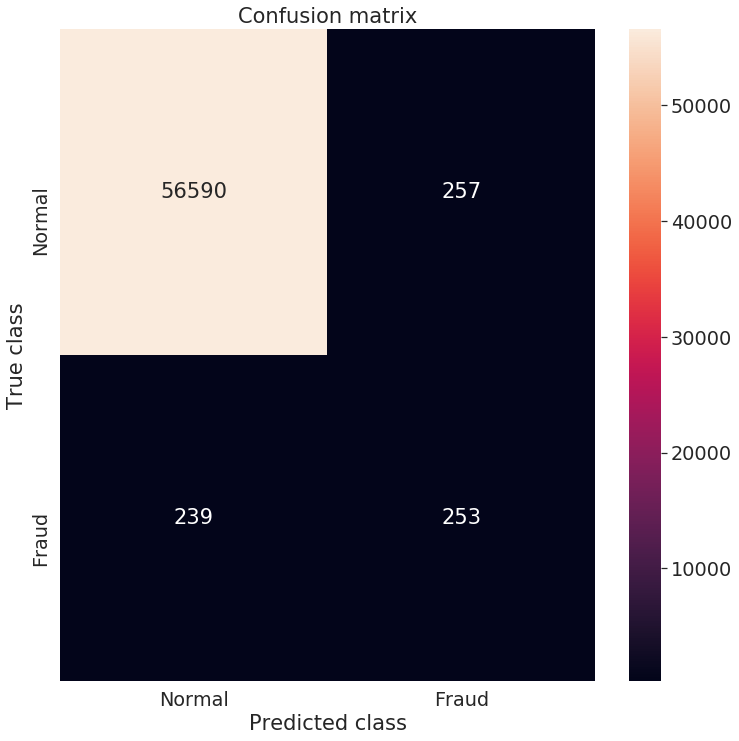

In [57]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Actual, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [58]:
preds_y_binary = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error]

print(classification_report(test_y_extended, preds_y_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56847
           1       0.50      0.51      0.50       492

   micro avg       0.99      0.99      0.99     57339
   macro avg       0.75      0.75      0.75     57339
weighted avg       0.99      0.99      0.99     57339



Recall has improved from 48% to 51%, and Precision has improved from 18% to 50%! However, the losistic regression model still had much better Recall at 84% and Precision at 68%.

## Logistic Regression with weighted classes

There is another approach to tackling the issue on an imbalanced dataset. 

The traditional approach is over-sampling or under-sampling. Over-sampling would be taking the minority class (fraud data) and replicating it a bunch until the datasets are balanced. The risk with this approach is that it leads towards over-fitting.

Under-Sampling is to cut out a bunch of the majority class (normal transactions) until the classes are balanced. The problem with this approach is that there is a dramatic loss of information, so the model does not generalize as well as it otherewise would.

Another method, similar in spirit but different in detail is weighting the classes during training. Keras's `fit()`  function has a parameter called `class_weights`. This lets you assign a weight to each of your classes.

This a way of handling imbalanced classes. Instead of tackling the problem on sampling side with over-sampling the minority class (fraud data), this parameter assists in taking bigger steps during optimization by giving more weight to the loss of the minority class, resulting in a similar outcome.

### Setup and Train

Setup the Model as before:

In [0]:
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

# split the data 80/20, training to testing
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)

train_y = train_x['Class']
train_x = train_x.drop(['Class'], axis=1)

test_y = test_x['Class']
test_x = test_x.drop(['Class'], axis=1)

# transform to ndarray
train_x = train_x.values
test_x = test_x.values

In [0]:
nb_epoch = 50
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30

model = Sequential()
model.add(Dense(120, input_shape=(input_dim,), activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(60, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

This time however we will introduce a dictionary of weights. We will assign labels of `0` (Normal Transactions) a weight of `1`. We will assign labels of `1` (Fraudulent Transactions) with a weight of `50`. This will heavlily favor (50:1) large step sizes when training on fraud data.

In [0]:
class_weight = {0 : 1., 1: 50.}

In [62]:
model.compile(metrics=['accuracy'],
                    loss='binary_crossentropy',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="logistic_regression_class-weighted_fraud.h5",
                               save_best_only=True,
                               verbose=0)

history = model.fit(train_x, train_y,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    class_weight=class_weight, # Pass in the class weights, 50:1
                    shuffle=True,
                    validation_data=(test_x, test_y),
                    verbose=1,
                    callbacks=[cp]).history

Train on 227845 samples, validate on 56962 samples
Epoch 1/50
227845/227845 [==============================] - 8s 36us/step - loss: 0.0831 - acc: 0.9901 - val_loss: 0.0096 - val_acc: 0.9992
Epoch 2/50
227845/227845 [==============================] - 7s 31us/step - loss: 0.0576 - acc: 0.9973 - val_loss: 0.0262 - val_acc: 0.9937
Epoch 3/50
227845/227845 [==============================] - 7s 31us/step - loss: 0.0520 - acc: 0.9969 - val_loss: 0.0160 - val_acc: 0.9971
Epoch 4/50
227845/227845 [==============================] - 7s 31us/step - loss: 0.0499 - acc: 0.9975 - val_loss: 0.0189 - val_acc: 0.9974
Epoch 5/50
227845/227845 [==============================] - 7s 33us/step - loss: 0.0481 - acc: 0.9974 - val_loss: 0.0123 - val_acc: 0.9977
Epoch 6/50
227845/227845 [==============================] - 7s 32us/step - loss: 0.0471 - acc: 0.9973 - val_loss: 0.0118 - val_acc: 0.9987
Epoch 7/50
227845/227845 [==============================] - 7s 32us/step - loss: 0.0439 - acc: 0.9975 - val_loss: 0

### Model Results

In [0]:
model = load_model('logistic_regression_class-weighted_fraud.h5')

In [0]:
# preds_y = model.predict_classes(test_x).flatten()
preds_y = model.predict(test_x).flatten()

In [65]:
error_df = pd.DataFrame({'Predictions': preds_y,
                        'Actual': test_y})
error_df.describe()

,Predictions,Actual
count,56962.000000,56962.000000
mean,0.003038,0.002019
std,0.047878,0.044887
min,0.000247,0.000000
25%,0.000256,0.000000
50%,0.000260,0.000000
75%,0.000271,0.000000
max,0.999743,1.000000


#### Recall vs Precision

We'll skip the ROC curve, since it is not useful, and go straight to the Recall vs Precision curve.

In [66]:
num_fraud = error_df.Actual[error_df.Actual == 1].count()
num_normal = error_df.Actual[error_df.Actual == 0].count()
no_skill_level = num_fraud/(num_fraud + num_normal)

num_fraud, num_normal, no_skill_level

(115, 56847, 0.0020188897861732383)

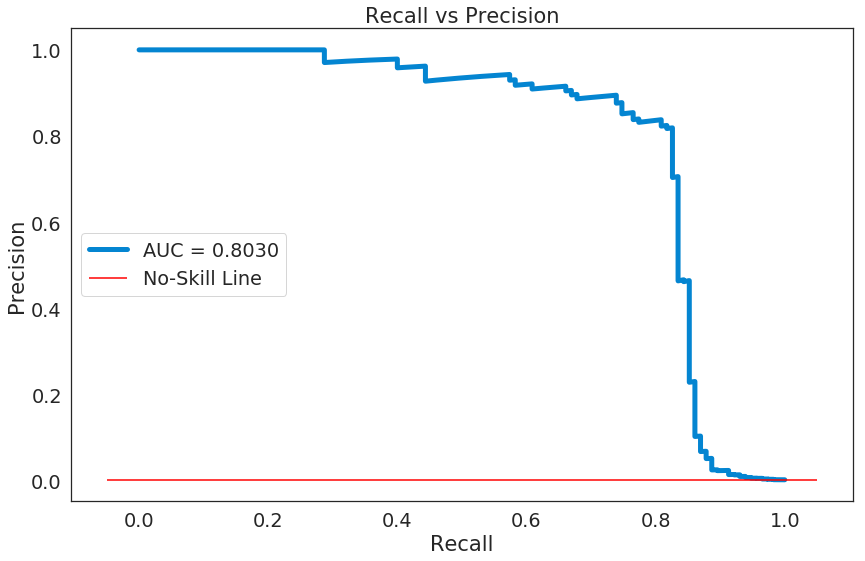

In [67]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.Actual, error_df.Predictions)
pr_auc = auc(recall_rt, precision_rt)
fig, ax = plt.subplots()
ax.plot(recall_rt, precision_rt, linewidth=5, label='AUC = %0.4f'% pr_auc)
ax.hlines(no_skill_level, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='No-Skill Line')
ax.legend(loc='center left')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

The results are somewhat interesting. The AUC is smaller than before 80% vs. 83.3%. Higher AUC is better, so this doesn't look ideal.



#### Threshold

Now we'll look at the Recall and Precision for different threshold values.

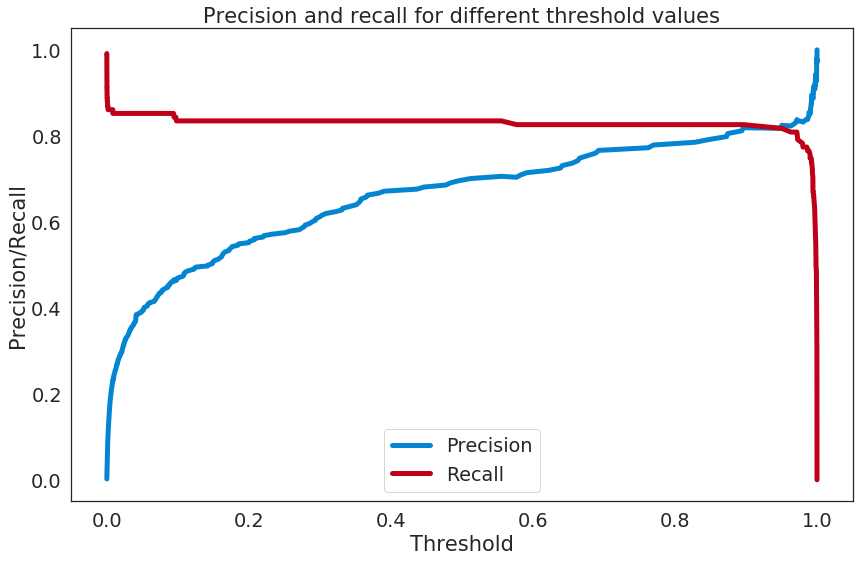

In [68]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

The results of applying class weights are much more apparent here. The results are significantly different than before. As we increase the threshold, for most values, we don't have much loss in Recall but we have a steadily increasing Precision. It seems as though the probabilities close to 1 are mostly True Positives.

We can look at the distribution to visualize. The threshold can be raised pretty high.

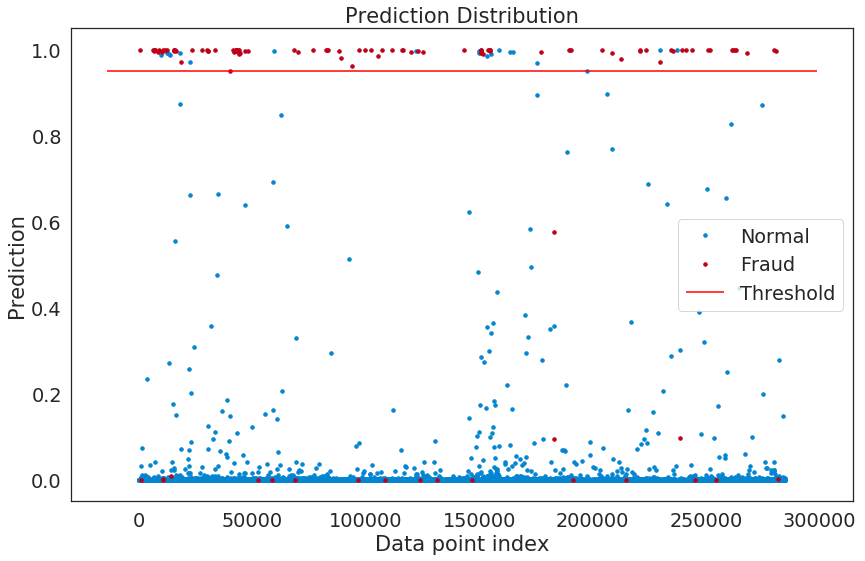

In [69]:
threshold_fixed = 0.95
groups = error_df.groupby('Actual')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Predictions, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Prediction Distribution")
plt.ylabel("Prediction")
plt.xlabel("Data point index")
plt.show();


The majority of fraud events have bubbled up to the top. This is why we don't lose much Recall as we raise the Threshold. Also The Normal events are scattered, but mostly distributed towards the lower probabilities. This is why Precision goes up steadily as we raise the threshold.

#### Final Tally

Here's the numbers:

In [70]:
preds_y_binary = [1 if e > threshold_fixed else 0 for e in error_df.Predictions]

print(classification_report(test_y, preds_y_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56847
           1       0.82      0.82      0.82       115

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



Recall and Precision or both quite good, at 82%.

The Confusion Matrix shows the numerical breakdown:

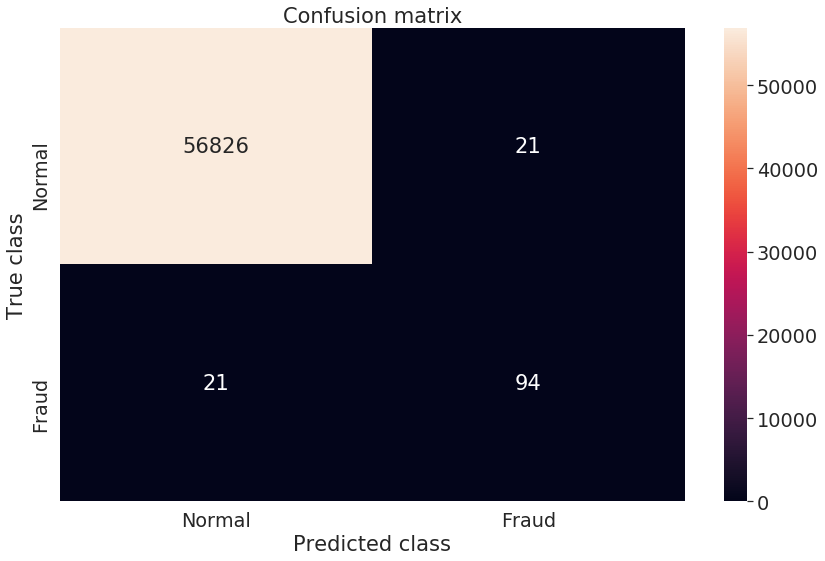

In [71]:
conf_matrix = confusion_matrix(test_y, preds_y_binary)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Sources

### Data

* [Credit Card Fraud Detection - Anonymized credit card transactions labeled as fraudulent or genuine](https://www.kaggle.com/mlg-ulb/creditcardfraud)

* [Statlog (Australian Credit Approval) Data Set](http://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval))

### Articles/Blogs

* [Fraud Detection Using Autoencoders in Keras with a TensorFlow Backend - David Ellison, PhD](https://www.datascience.com/blog/fraud-detection-with-tensorflow)

* [Credit Card Fraud Detection using Autoencoders in Keras - Venelin Valkov](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd)

* [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python - Jason Brownlee](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

* [Simple Approach for Handling Imbalanced Dataset - Credit Card Fraud Detection](http://www.coderschool.vn/blog/simple-approach-for-handling-imbalanced-dataset-credit-card-fraud-detection/)

* [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)

* From Logistic Regression in SciKit-Learn to Deep Learning with TensorFlow: A fraud detection case study - Matthias Groncki

  * [Part I](https://ipythonquant.wordpress.com/2018/05/08/from-logistic-regression-in-scikit-learn-to-deep-learning-with-tensorflow-a-fraud-detection-case-study-part-i/)

  * [Part II](https://ipythonquant.wordpress.com/2018/05/18/from-logistic-regression-in-scikit-learn-to-deep-learning-with-tensorflow-a-fraud-detection-case-study-part-ii/)

  * [Part III](https://ipythonquant.wordpress.com/2018/06/20/from-logistic-regression-in-scikit-learn-to-deep-learning-with-tensorflow-a-fraud-detection-case-study-part-iii/)
  
* [What to do when the labels are skewed: tackling the Accuracy Paradox - Mark Ryan](https://medium.com/@markryan_69718/what-to-do-when-the-labels-are-skewed-tackling-the-accuracy-paradox-7b72bd4a9ccc)